# Milk Production, Weather, and Animal Classifications

The following document is an initial inspection of data regarding, milk volumes, weather and animal ratings for a dairy farm in Central Pennsylvania.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
engine =  create_engine('sqlite:///../../data/database/happycows.db')
with engine.connect() as con:
    milk_volumes = pd.read_sql_table('milk_volume', con)
    weather = pd.read_sql_table('weather', con)
    classification = pd.read_sql_table('classification', con)

### Question: What is the composition of the herd?

The classification system provides a final score (0-100) range. By plotting the final scores from the classification data set we can see the distribution of animal scores about the 'ideal' milking cow (i.e. score of 100). The histogram below shows the majority of the cows scoring between 80 and 85 points.

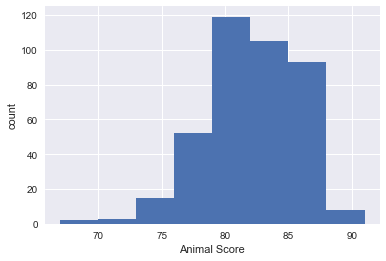

In [3]:
# Reindex to each cow and date combination
c = classification.set_index(['animal_id', 'date'])

sns.set()
plt.hist(c['final_score'].dropna(), bins=8)
plt.xlabel('Animal Score')
plt.ylabel('count')
plt.show()

### Question: What is the distribution of milk production?

At the dairy farm in question, milkings occur twice daily.  Animals may not participate in both milkings in a given day, as a result rather than looking at a pounds-per-day metric, we can examine the distribution of milk weights below.  The following histogram shows that the majority of cows on this farm produced approximately between 10 and 20 pounds of milk per milking or between 1.2 and 2.5 gallons.

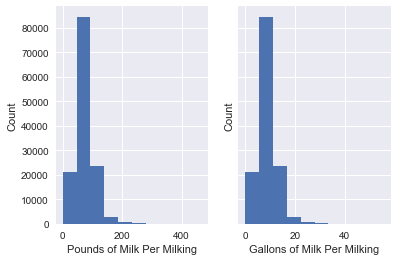

In [4]:
m = milk_volumes['milk_weight'].dropna()
g = m / 8.35 # The average gallon of milk weighs approximately 8.35 pounds 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(m, bins=10)
ax1.set_xlabel('Pounds of Milk Per Milking')
ax1.set_ylabel('Count')

ax2.hist(g, bins=10)
ax2.set_xlabel('Gallons of Milk Per Milking')
ax2.set_ylabel('Count')

plt.show()

### What is the temperature profile of the region?

Examining a plot of the minimum and maximum temperatures from multiple over time, indicate a median monthly maximum temperature in the low 80's (F) occurring in July and August, and a median monthly low temperature in the mid 10's (F) in January and February.

In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 9 columns):
index          1420 non-null int64
date           1420 non-null datetime64[ns]
prcp           1420 non-null float64
tmin           1416 non-null float64
tmax           1416 non-null float64
is_hot         1420 non-null bool
is_heatwave    1420 non-null bool
is_cold        1420 non-null bool
is_coldwave    1420 non-null bool
dtypes: bool(4), datetime64[ns](1), float64(3), int64(1)
memory usage: 61.1 KB


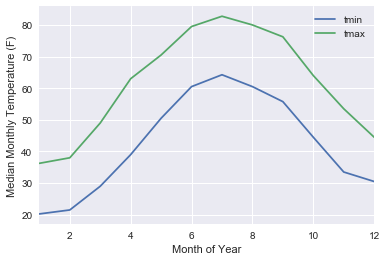

In [6]:
t_monthly = weather[['tmin','tmax', 'date']].groupby(weather['date'].dt.month).median()
t_monthly.plot(kind='line')
plt.ylabel('Median Monthly Temperature (F)')
plt.xlabel('Month of Year')
plt.show()

### Question: Does milk production vary seasonally?

Now having done a preliminary visual analysis of weather and herd composition, plotting the median milk production per milking by the week of the calendar year, does show a seasonal trend of increased milk pounds produced per animal from the 10th week (March) to the 20th week (May) of the calendar year.

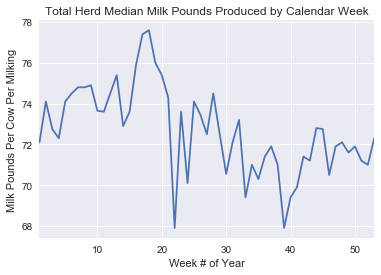

In [7]:
milk_volumes['milk_weight'].groupby(milk_volumes['date'].dt.week).median().plot()
plt.xlabel('Week # of Year')
plt.ylabel('Milk Pounds Per Cow Per Milking')
plt.title('Total Herd Median Milk Pounds Produced by Calendar Week')
plt.show()

### Question: Is there a relation between the classification score and the pounds of milk produced?

By plotting each animals, median-per-milking pounds produced, against their assigned final classification score there does not appear to be a strong relationship to the top-line final score and pounds of milk produced per milking. Examining the data does indicate some outliers of high and low production. Plotting median milk production versus the age and breed adjusted "Breed Age Average" displays a series of outliers that requires the exclusion of outliers outside of the logical range (> 150). The resulting plots suggest that cows are clustered in the 15 to 20 pounds per milking range of production.

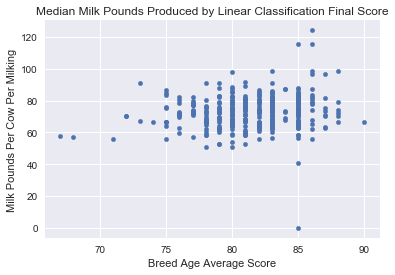

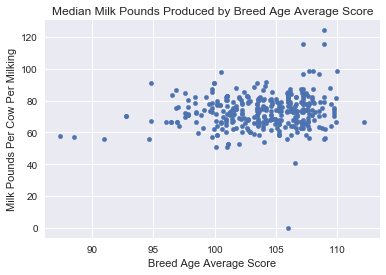

In [8]:
animal_class = classification[['animal_id', 'final_score', 'category', 'breed_age_average']].dropna()
median_milk_by_animal = milk_volumes[['date', 'animal_id', 'milk_weight']].dropna().groupby(['animal_id']).median().reset_index()
animal_production_and_scores = pd.merge(left=animal_class, right=median_milk_by_animal, left_on='animal_id', right_on='animal_id', how='left').dropna()
a = animal_production_and_scores.reset_index()
a.plot(kind='scatter', x='final_score', y='milk_weight')
plt.xlabel('Breed Age Average Score')
plt.ylabel('Milk Pounds Per Cow Per Milking')
plt.title('Median Milk Pounds Produced by Linear Classification Final Score')
plt.show()

a = a[a['breed_age_average'] < 150]
a.plot(kind='scatter', x='breed_age_average', y='milk_weight')
plt.xlabel('Breed Age Average Score')
plt.ylabel('Milk Pounds Per Cow Per Milking')
plt.title('Median Milk Pounds Produced by Breed Age Average Score')
plt.show()

### Does each 'category' of cattle experience similar seasonality in production?

Plotting the median weekly milk production for each animal category reveals a similar pattern of seasonality in milk production, with slight variations in timing and magnitude.

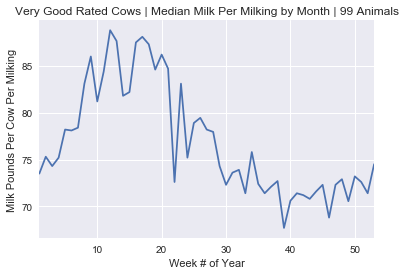

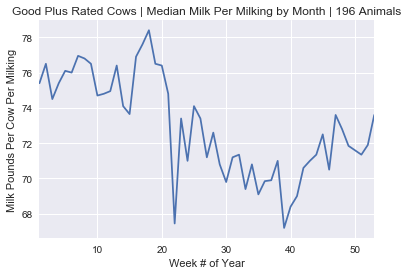

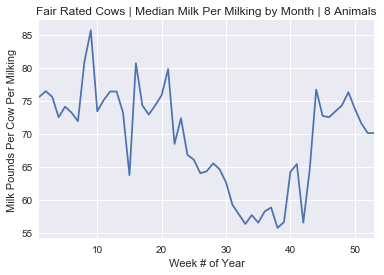

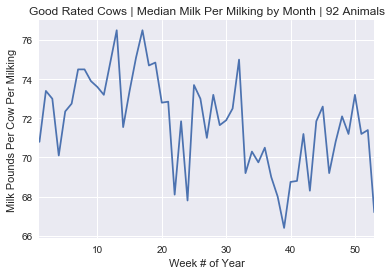

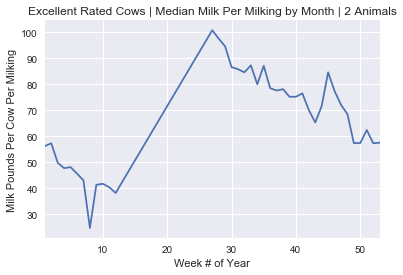

In [9]:
animals = classification[['animal_id', 'final_score', 'category']]
volumes = milk_volumes[['date', 'animal_id', 'milk_weight']]

classification_list = a['category'].unique()
animals_and_volumes = pd.merge(left=animals.dropna(), right=volumes.dropna(), left_on='animal_id', right_on='animal_id')

for classification in classification_list:
    animal_count = animals[animals['category'] == classification]['category'].count()
    plot = animals_and_volumes[animals_and_volumes['category'] == classification]
    plot['milk_weight'].groupby(plot['date'].dt.week).median().plot()
    plt.xlabel('Week # of Year')
    plt.ylabel('Milk Pounds Per Cow Per Milking')
    plt.title(f'{classification} Rated Cows | Median Milk Per Milking by Month | {animal_count} Animals')
    plt.show()

## Conclusion

The overall trend in milk production is a seasonal peak in milk production in the spring months and depression in milk production during the winter months.  Animals of all classification categories experienced a similarly shaped seasonal trend in production.

## Additional Questions

- Do individual components of the linear classification have a stronger correlation with milk production?
- Do heat or cold snaps have identifiable impacts on milk production?
- Do the number of days since giving birth to a calf have a measurable impact on milk production?
- Is the seasonal trend in milk production attributable to the herd having a large number of calves in the spring?
- Do the attributes of the milk produced such as butterfat or somatic cell count follow seasonal trends?
- What is the monetary value of the milk produced by a given cow?
- What portion of the retail price of a gallon of milk is attributable to the farmer?
- How is the total cost of a gallon of milk allocated between the involved such as the farmer, manufacturer, distributor, and retailer.